In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle as pk,numpy as np, warnings
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.gridspec import GridSpec as gs
import seaborn as sns
from scipy import stats
import pandas as pd

In [3]:
warnings.filterwarnings('ignore')
#load reporter data
deg_stats = pd.read_excel("/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Important_references/Deg_stats_final_pub.xlsx").drop(columns=['Unnamed: 0'])
ref = pd.read_excel('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Important_references/Flow_well_keys_pub.xlsx')

#Remove control strain rows from the deg_stats file
msm_filtered = deg_stats[deg_stats['Substrate']!='No Target'].copy()

# group strains by their deg constant
msm_filtered['Deg_group']=(msm_filtered['log2(Deg constant)'].values>-6)*1

# plate5 as validation set
msm_filtered['as_validation'] = [1 if x in ref[ref['Plate']=='Plate5']['Locus_tag'].unique() else 0 for x in msm_filtered['Locus']]

import pickle as pk
ortho_table = pk.load(open('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_draft/Tables/union_ortho_table_withFeatures.pk','rb'))

msm_filtered['flDPnn_disorder_propensity'] =  ortho_table.loc[msm_filtered['Locus'],'flDPnn_disorder_propensity']


N_term_list = []
C_term_list = []
full_list = []
term_length = 30

for g in msm_filtered['Locus'].values:
    flDPnn_string = ortho_table.loc[g,'flDPnn_disorder_propensity']
    N_term_list.append(flDPnn_string[:term_length])
    C_term_list.append(flDPnn_string[-term_length:])

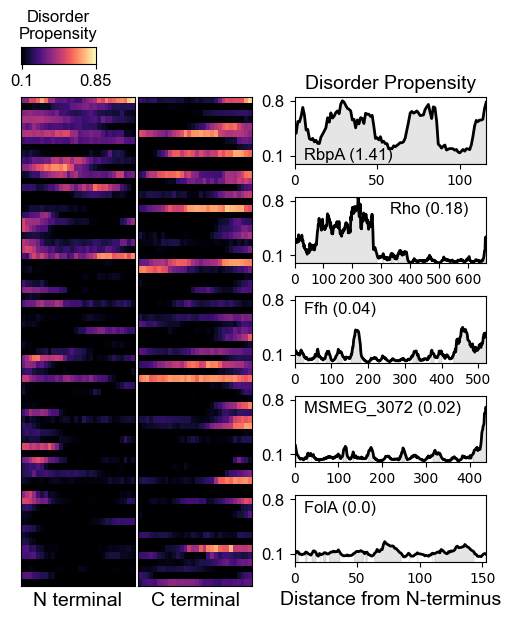

In [216]:
#fig,axes=plt.subplots(figsize=(4,6),ncols=2,gridspec_kw={'wspace':0.05})
fig=plt.figure(figsize=(6,7))
grids = gs(22,12,wspace=0.1,hspace=0.5)
axes = [fig.add_subplot(grids[2:,:3]),
        fig.add_subplot(grids[2:,3:6]),
        fig.add_subplot(grids[0,:2]),
        fig.add_subplot(grids[2:5,7:]),
        fig.add_subplot(grids[6:9,7:]),
        fig.add_subplot(grids[10:13,7:]),
        fig.add_subplot(grids[14:17,7:]),
        fig.add_subplot(grids[18:21,7:])]
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xticks([])
axes[0].imshow(np.array(N_term_list),aspect='auto',vmin=0.1,vmax=0.85,cmap='magma')
axes[1].imshow(np.array(C_term_list),aspect='auto',vmin=0.1,vmax=0.85,cmap='magma')

axes[2].imshow(np.linspace(0,1,100).reshape(-1,1).T,aspect='auto',cmap='magma')
axes[2].set_xticks([0,100])
axes[2].set_xticklabels([0.1,0.85],fontname='Arial',fontsize=12)
axes[2].set_yticks([])
axes[2].set_title('Disorder\nPropensity',fontname='Arial')
axes[0].set_xlabel('N terminal',fontname='Arial',fontsize=14)
axes[1].set_xlabel('C terminal',fontname='Arial',fontsize=14)

for i,j in enumerate([0,6,32,48,69]):
    ax = axes[i+3]
    locus = msm_filtered['Locus'].values[j]
    name = msm_filtered['Substrate'].values[j]
    deg = msm_filtered['Deg constant'].values[j]
    flDPnn_v = ortho_table.loc[locus,'flDPnn_disorder_propensity']
    ax.plot(np.arange(len(flDPnn_v)),flDPnn_v,lw=2,color='black')
    ax.set_ylim(0,0.85)
    ax.set_yticks([0.1,0.8],labels=[0.1,0.8])
    ax.set_yticklabels([0.1,0.8],fontname='Arial',fontsize=12)
    ax.fill_between(np.arange(len(flDPnn_v)),
                    y1=np.zeros(len(flDPnn_v)),
                    y2=flDPnn_v,alpha=0.2,where=flDPnn_v>0.1,color='grey')
    ax.set_xlim(0,len(flDPnn_v)-1)
    if len(flDPnn_v)<200:
        ax.set_xticks(np.arange(0,len(flDPnn_v),50))
    else:
        ax.set_xticks(np.arange(0,len(flDPnn_v),100))
    if i==4:
        ax.set_xlabel('Distance from N-terminus',fontname='Arial',fontsize=14)
    if i==0:
        ax.set_title('Disorder Propensity',fontname='Arial',fontsize=14)
    if i>1:
        ax.text(0.05,0.81,'{} ({})'.format(name,round(deg,2)),transform=ax.transAxes,ha='left',va='center',fontsize=12,
                fontname='Arial')
    elif i==1:    
        ax.text(0.5,0.81,'{} ({})'.format(name,round(deg,2)),transform=ax.transAxes,ha='left',va='center',fontsize=12,fontname='Arial')
    else:
        ax.text(0.05,0.12,'{} ({})'.format(name,round(deg,2)),transform=ax.transAxes,ha='left',va='center',fontsize=12,fontname='Arial')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_degradation_flDPnn.svg',
            bbox_inches='tight')

In [148]:
def flDPnn_full_fig(gname,flDPnn_string,term_length=30):
    fig=plt.figure(figsize=(6,1.5))
    grids = gs(1,5)
    ax1 = fig.add_subplot(grids[:,0])
    ax2 = fig.add_subplot(grids[:,1:-1])
    ax3 = fig.add_subplot(grids[:,-1])
    for ax in [ax1,ax2,ax3]:
        ax.set_ylim(0,0.8)
        ax.fill
    ax1.plot(flDPnn_string[:term_length])
    ax1.fill_between(np.arange(term_length),y1=np.zeros(term_length)*0.1,y2=flDPnn_string[:term_length],alpha=0.2,
                    where=flDPnn_string[:term_length]>0.1)
    ax3.plot(flDPnn_string[-term_length:])
    ax3.fill_between(np.arange(term_length),y1=np.zeros(term_length)*0.1,y2=flDPnn_string[-term_length:],alpha=0.2,
                      where=flDPnn_string[-term_length:]>0.1)
    l = len(flDPnn_string)
    ax2.fill_between(np.arange(l),y1=np.zeros(l)*0.1,y2=flDPnn_string,alpha=0.2,where=flDPnn_string>0.1)
    ax1.hlines(y=0.1,xmin=0,xmax=term_length)
    ax3.hlines(y=0.1,xmin=0,xmax=term_length)
    ax2.hlines(y=0.1,xmin=0,xmax=l)
    ax2.plot(flDPnn_string)
    ax2.set_yticks([])
    ax3.set_yticks([])
    ax1.set_xlim(0,term_length-1)
    ax3.set_xlim(0,term_length-1)
    ax2.set_xlim(0,-1)

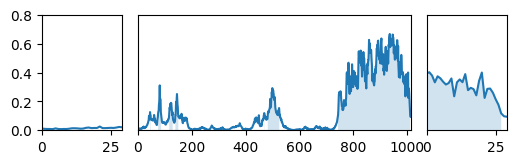

In [46]:
flDPnn_full_fig('MSMEG_0250',ortho_table.loc['MSMEG_0250','flDPnn_disorder_propensity'])